<a href="https://colab.research.google.com/github/Vikas-KM/quora-question-pair/blob/main/solving_quora_question_pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [ ]:
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import math
import gc
import re

from bs4 import BeautifulSoup

from fuzzywuzzy import fuzz
import tqdm
from tqdm import notebook
from difflib import SequenceMatcher
from wordcloud import WordCloud


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
zf = zipfile.ZipFile('/kaggle/input/quora-question-pairs/train.csv.zip')
df_train = pd.read_csv(zf.open('train.csv'))
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Examples of duplicate examples

In [ ]:
# change the index of iloc to see different questions to get and idea
df1 = df_train[df_train['is_duplicate'] == 0]
df2 = df_train[df_train['is_duplicate'] == 1]

qstn1 = df1.iloc[0]['question1']
qstn2 = df1.iloc[0]['question2']
is_dup1 = df1.iloc[0]['is_duplicate']

qstn3 = df2.iloc[0]['question1']
qstn4 = df2.iloc[0]['question2']
is_dup2 = df2.iloc[0]['is_duplicate']


print(qstn1)
print(qstn2)
print('are they duplicates? ', is_dup1)

print(qstn3)
print(qstn4)
print('are they duplicates? ', is_dup2)

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?
are they duplicates?  0
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
are they duplicates?  1


## basic analysis on the train data

In [ ]:
# how many data points
df_train.shape

(404290, 6)

In [ ]:
# names of the columns
df_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [ ]:
# how is data spread, finding the balance/imbalance of the data
df_train['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [ ]:
# any null values present
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
print('{}% of duplicate pairs of question'.format(round(df_train['is_duplicate'].mean()*100,2)))

36.92% of duplicate pairs of question


## Exploratory Data Analysis

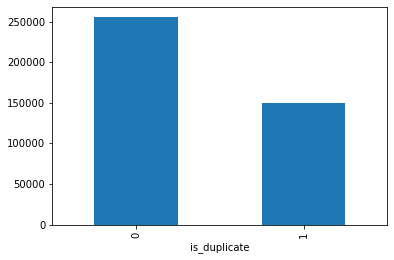

In [ ]:
# count of duplicate and not duplicate questions
df_train.groupby('is_duplicate')['id'].count().plot.bar()


### references
- https://datatofish.com/convert-pandas-dataframe-to-list/
- https://queirozf.com/entries/pandas-dataframe-examples-duplicated-data

In [ ]:
df_train['qid1'].value_counts()

8461      50
14110     48
25984     47
20628     47
1749      47
          ..
415339     1
411241     1
413288     1
409190     1
524288     1
Name: qid1, Length: 290654, dtype: int64

In [ ]:
df_train['qid2'].value_counts()

30782     120
2559      115
4044      100
2561       71
17978      66
         ... 
99475       1
105616      1
85130       1
525311      1
288755      1
Name: qid2, Length: 299364, dtype: int64

### Observations
- Some qids are repeated, that means few questions are repeating

In [ ]:
# number of unique questions
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
total_qstns = len(qids)
unique_qstns = len(np.unique(qids))
repeated_qstns = np.sum(qids.value_counts() >1)
print('Total number of questions ',total_qstns)
print('Total number of uniques questions ',unique_qstns)
print('Total number of repeated questions',repeated_qstns)


Total number of questions  808580
Total number of uniques questions  537933
Total number of repeated questions 111780


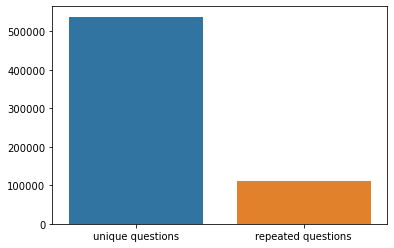

In [ ]:
x=['unique questions', 'repeated questions']
y=[unique_qstns, repeated_qstns]
sns.barplot(x, y)

In [ ]:
# how many times questions are repeated max?
qids.value_counts().iloc[:10]

2559     157
30782    120
4044     111
2561      88
14376     79
17978     77
2675      68
28764     66
1772      63
24555     61
dtype: int64

Text(0, 0.5, 'Number of questions')

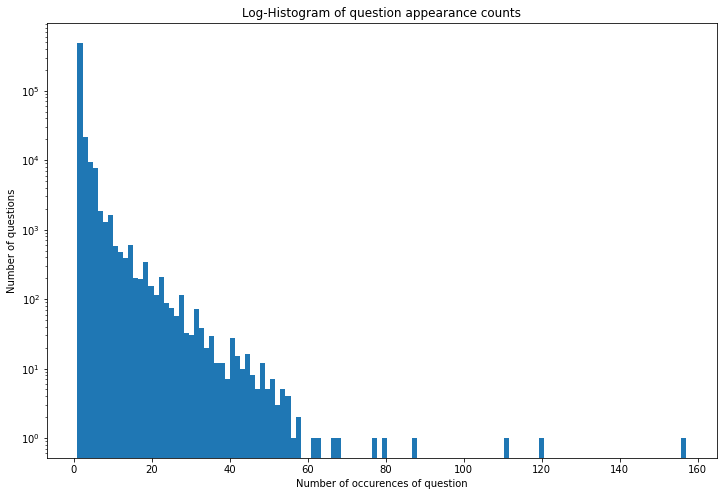

In [ ]:
# questions are in huge numbers so taking logscale for y axis
# nonposy=clip mean negative of log not defined so here a small value is taken

plt.figure(figsize=(12, 8))
plt.hist(qids.value_counts(), bins=120)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

### Observations
- As from the above plot we can see, there is a question that is repeated 157, 120, 111 times
( see the above plot query for 157 number)

In [ ]:
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
# finding rows that have NaN values
df_train[df_train.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
gc.collect()

771941

### Observations
- There are 3 rows which have NaN value
    - we can delete those rows
    - we can fill them with a empty string
    
   
Since the NaN value are only 3 we will discard/drop them

### references
- https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [ ]:
# droping the NaN values
df_train.dropna(axis=0, how='any', inplace=True)

In [ ]:
df_train[df_train.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [ ]:
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
df_train.shape

(404287, 6)

In [ ]:
## Checking if any pair is duplicate
dup = df_train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
df_train.shape[0] - dup.shape[0]
del dup

### Naive Submission

In [ ]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

# zf = zipfile.ZipFile('/kaggle/input/quora-question-pairs/test.csv.zip')
# df_test = pd.read_csv(zf.open('test.csv'))

df_test = pd.read_csv('/kaggle/input/quora-question-pairs/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()


Predicted score: 0.658528851473067


,test_id,is_duplicate
0,0,0.369201
1,1,0.369201
2,2,0.369201
3,3,0.369201
4,4,0.369201


In [ ]:
df = pd.read_csv('./naive_submission.csv')
df.shape

(2345796, 2)

## Feature Engineering

### Lets create a few new Features
- **freq_qid1, freq_qid2** -> Frequency count of the qids
- **qlen1, qlen2** -> Length of the question

- **q1_words, q2_words** -> Number of words in the question

In [ ]:
# copying the df_train to df
df = df_train.copy()
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Cleaning for RAM Management later

In [ ]:
del df_train
del df_test
del df1
del df2
gc.collect()

20

### References
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html
- https://pbpython.com/pandas_transform.html

In [ ]:
# using pandas transform to count the frequency of the qstn based on qid
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1


In [ ]:
# finding the length of the qstn and creating a new feature
df['qlen1'] = df['question1'].apply(lambda x:len(x))
df['qlen2'] = df['question2'].apply(lambda x:len(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39


In [ ]:
# number of words in the questions
df['q1_words'] = df['question1'].apply(lambda x: len(x.split(' ')))
df['q2_words'] = df['question2'].apply(lambda x: len(x.split(' ')))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


### References
- https://stackoverflow.com/questions/11938964/how-to-find-common-words-and-print-them-using-python-command/12136296

    - common = set(document_1_words).intersection( set(document_2_words) )
    - unique = set(document_1_words).symmetric_difference( set(document_2_words) )
    
    
- **common_words** -> common words to question1 and question2
- **total_words** -> total unique words to belonging to both question1 and question2
- **share_words** -> the share words is defined as common words divided by total words

In [ ]:
# common words to both qstn1 and qstn2 
def word_common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return len(w1.intersection(w2))
df['common_words'] = df.apply(word_common, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2


In [ ]:
# Total words of both qstn1 and qstn2 
def word_total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return len(w1)+len(w2)
df['total_words'] = df.apply(word_total, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20


In [ ]:
# words shared between of both qstn1 and qstn2 
# gives us an idea as to how similar the two qstns maybe
# higher the share words implies more similar the wordings are of the two sentences

df['share_words'] = df['common_words']/(df['total_words'])
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000


- **freq_q1+freq_q2** = sum total of frequency of qid1 and qid2
- **freq_q1-freq_q2** = absolute difference of frequency of qid1 and qid2

In [ ]:
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

### Analysis from the extracted features

In [ ]:
# minimum length of the question1
print('minimum length of the qstn1 is ',min(df['qlen1']))

# minimum length of the question2
print('minimum length of the qstn2 is ',min(df['qlen2']))

minimum length of the qstn1 is  1
minimum length of the qstn2 is  1


In [ ]:
# questions of minimum length
print(df[df['qlen1']== 1].shape[0])
df[df['qlen1']== 1]['question1']

19


3306      .
13016     ?
20794     ?
96725     ?
104101    ?
108978    i
115347    o
134403    ?
151922    o
158778    A
189659    ?
190570    ‘
199110    I
208485    ?
213220    ?
254161    ?
273065    ?
357127    H
402423    ?
Name: question1, dtype: object

In [ ]:
print(df[df['qlen2']== 1].shape[0])
df[df['qlen2']== 1]['question2']

2


47056     ?
198913    o
Name: question2, dtype: object

In [ ]:
df.shape[0]

404287

### Observation
- There are 19 questions of Question1 which has only 1 character
- There are 2 questions of Question2 which has only 1 character

These 21 form a miniscule part(0.005%) of the training, we can drop them

In [ ]:
min(df['q1_words'])

1

In [ ]:
print(df[df['q1_words']== 1].shape[0])
df[df['q1_words']== 1]['question1']
print(df[df['q1_words']== 1]['question1'].value_counts())

66
?            11
deleted       9
Deleted.      5
What?         4
Why?          2
My            2
o             2
Nana          1
i             1
sss           1
I             1
spam          1
Cloning?      1
Na            1
delete        1
no            1
civil         1
Q?            1
Which         1
HH            1
…..           1
hi            1
What          1
Marriage      1
Error         1
.             1
Can?          1
‘             1
grammar       1
Aaas          1
[removed]     1
Life:         1
Ok            1
H             1
Is?           1
111           1
A             1
How           1
Name: question1, dtype: int64


In [ ]:
min(df['q2_words'])

1

In [ ]:
print(df[df['q2_words']== 1].shape[0])
df[df['q2_words']== 1]['question2']
print(df[df['q2_words']== 1]['question2'].value_counts())

22
What?            3
…………..           2
Deleted.         2
Spam             2
deleted          1
Edit             1
Does?            1
o                1
Why              1
[removed]        1
Delete           1
lol              1
parisflatlist    1
????             1
Hh               1
HH               1
?                1
Name: question2, dtype: int64


In [ ]:
df[df['question2']=='Spam']

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
236655,236655,153211,347631,Why was spam is called spam?,Spam,0,1,2,28,4,6,1,1,7,0.142857,3,1
361480,361480,491330,347631,"As a 13 year old, how do I get out of my unliv...",Spam,0,1,2,57,4,14,1,0,15,0.000000,3,1


In [ ]:
df[df['question2']=='deleted']

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
231313,231313,179756,341088,From where to download episode2 season 3 of Th...,deleted,0,1,1,54,7,10,1,0,11,0.0,2,0


### Observations
- There are 66 and 22 question with one word in question1 and Question2
- bunch of keywords are deleted/delete spam and lol and dots conveying nothing at all

In [ ]:
df['share_words'][0:].head()

0    0.434783
1    0.200000
2    0.166667
3    0.000000
4    0.100000
Name: share_words, dtype: float64

##### Can the share_words be used to see if it will help to separate the given question pairs?

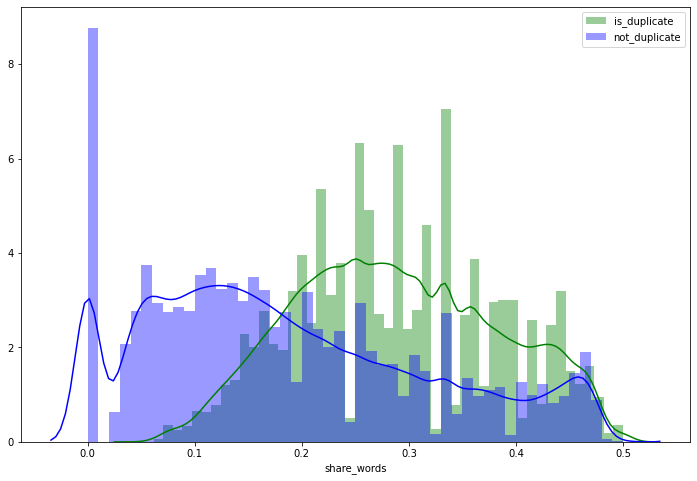

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 1.0]['share_words'], label = "is_duplicate", color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['share_words'], label = "not_duplicate" , color = 'blue' )
plt.legend()
plt.show()

### Observation
- green indicates duplicates, higher share words means they may be duplicates
- blue indicates not duplicates, lower share words means they may not be duplicates

Since there is lot of overlap it is not strict separation as can be seen from the above graph

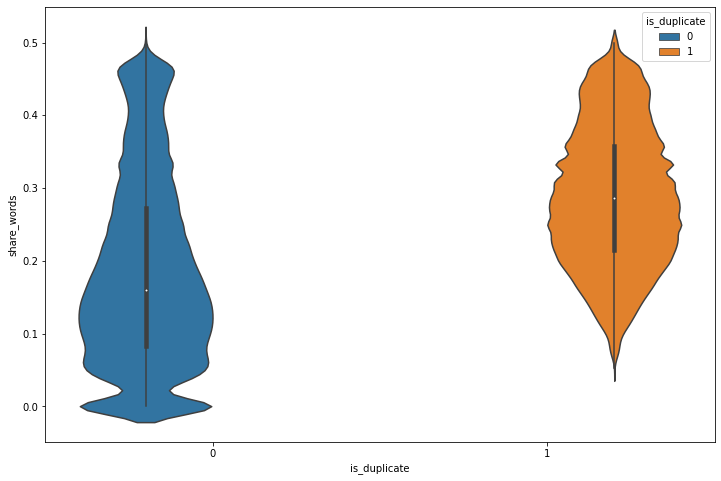

In [ ]:
plt.figure(figsize=(12,8))
x = df['is_duplicate']
y = df['share_words']
sns.violinplot(x,y, hue=df['is_duplicate'])
plt.show()

##### Can the common_words be used to see if it will help to separate the given question pairs?

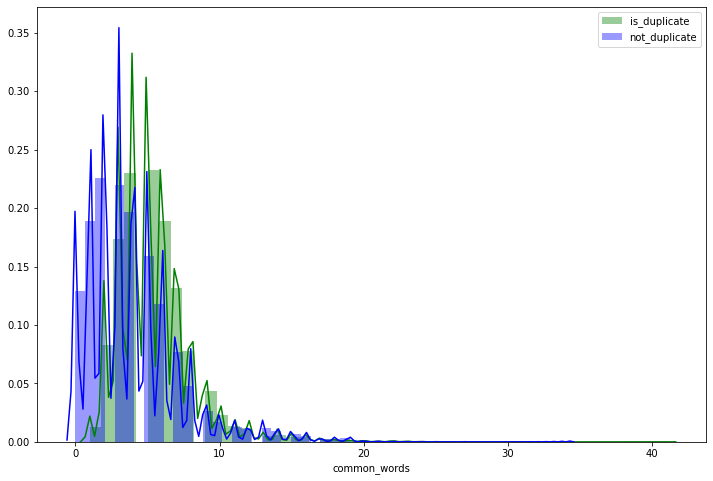

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 1.0]['common_words'], label = "is_duplicate", color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_words'], label = "not_duplicate" , color = 'blue' )
plt.legend()
plt.show()

#### Observation:
- too much overlap

## Text Preprocessing

- Removing HTML Tags
- Removing Punctuations
- Removing Numbers
- Performing Stemming
- Removing Stop words etc

#### Code to remove URL links from text

In [ ]:
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
def remove_URL(text):
    """Remove URLs from a text string"""
    return re.sub(r"http\S+", "", text)

In [ ]:
df['question1'] = df['question1'].apply(lambda x: x.lower())
df['question2'] = df['question2'].apply(lambda x: x.lower())

In [ ]:
df['question1'] = df['question1'].apply(lambda x: remove_URL(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [ ]:
df['question2'] = df['question2'].apply(lambda x: remove_URL(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
def getText(x):
    soup = BeautifulSoup(x, 'lxml')
    text = soup.get_text()
    return text

In [ ]:
df['question1'] = df['question1'].apply(lambda x: getText(x))
df.head()

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:312: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [ ]:
df['question2'] = df['question2'].apply(lambda x: getText(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


#### Expanding English language contractions in Python

In [ ]:
! pip install contractions

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
import contractions

print(contractions.fix("i like this and 'll and you've"))
print(contractions.fix("he's"))
print(contractions.fix("'ll"))

i like this and  will and you have
he is
 will


In [ ]:
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490

# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won\'t", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

In [ ]:
# removing special characters
def remove_spl(x):
    x = re.sub('[^A-Za-z0-9]+', '', x)
    return x

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


### Text Preprocessing
- Remove stop words
- remove html tags
- remove punctuations
- Stemming
- Expanding contractions

In [ ]:
def preprocess(x):
    x = str(x).lower()
    x = contractions.fix(x)
#     x = BeautifulSoup(x, 'lxml').get_text()
    x = re.sub('[^A-Za-z0-9]+', ' ', x) 
    return x.strip()

## Advanced Feature Extraction
- **Token** - is when a sentence is split on space
- **stop_words** - stop words according to NLTK
- **word** - A token that is not stop word


- **cwc_min** : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
- cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


- **cwc_max** : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
- cwc_max = common_word_count / (max(len(q1_words), len(q2_words))


- **csc_min** : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
- csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))


- **csc_max** : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
- csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))


- **ctc_min** : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
- ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))


- **ctc_max** : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
- ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


- **last_word_eq** : Check if last word of both questions is equal or not
- last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


- **first_word_eq** : Check if First word of both questions is equal or not
- first_word_eq = int(q1_tokens[0] == q2_tokens[0])


- **abs_len_diff** : Abs. length difference
- abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


- **mean_len** : Average Token Length of both Questions
- mean_len = (len(q1_tokens) + len(q2_tokens))/2




- fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage 
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- **longest_substr_ratio** : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
- longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

- https://stackoverflow.com/questions/29050292/python3-x-list-assignment-index-out-of-range
- https://stackoverflow.com/questions/9272849/beginner-python-set-intersection-error

In [ ]:
SAFE_DIV = 0.0001

def get_token_features(q1,q2):
    features = [0.0]*10
    q1_tokens = q1.split(' ')
    q2_tokens = q2.split(' ')
    q1_words = set([word for word in q1_tokens if word not in stop_words])
    q2_words = set([word for word in q2_tokens if word not in stop_words])
    q1_stops = set([word for word in q1_tokens if word in stop_words])
    q2_stops = set([word for word in q2_tokens if word in stop_words])
    
    common_word_count = len(q1_words.intersection(q2_words))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    features[0] = (common_word_count)/(min(len(q1_words), len(q2_words))+ SAFE_DIV)
    features[1] = (common_word_count)/(max(len(q1_words), len(q2_words))+ SAFE_DIV)
    
    features[2] = (common_stop_count)/(min(len(q1_stops), len(q2_stops))+ SAFE_DIV)
    features[3] = (common_stop_count)/(max(len(q1_stops), len(q2_stops))+ SAFE_DIV)
    
    features[4] = (common_token_count)/(min(len(q1_tokens), len(q2_tokens))+ SAFE_DIV)
    features[5] = (common_token_count)/(max(len(q1_tokens), len(q2_tokens))+ SAFE_DIV)
    
    features[6] = int(q1_tokens[0] == q2_tokens[0])
    features[7] = int(q1_tokens[-1] == q2_tokens[-1])
    features[8] = abs(len(q1_tokens) - len(q2_tokens))
    features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return features
    
    

In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'qlen1', 'qlen2', 'q1_words', 'q2_words',
       'common_words', 'total_words', 'share_words', 'freq_q1+q2',
       'freq_q1-q2'],
      dtype='object')

In [ ]:


df['question1'] = df['question1'].apply(lambda x: preprocess(x))
df['question2'] = df['question2'].apply(lambda x: preprocess(x))

   
# features = df.apply(lambda x: get_token_features(x['question1'],x['question2']))

# df["cwc_min"]       = list(map(lambda x: x[0], features))
# df["cwc_max"]       = list(map(lambda x: x[1], features))
# df["csc_min"]       = list(map(lambda x: x[2], features))
# df["csc_max"]       = list(map(lambda x: x[3], features))
# df["ctc_min"]       = list(map(lambda x: x[4], features))
# df["ctc_max"]       = list(map(lambda x: x[5], features))
# df["first_word_eq"]  = list(map(lambda x: x[6], features))
# df["last_word_eq"] = list(map(lambda x: x[7], features))
# df["abs_len_diff"]  = list(map(lambda x: x[8], features))
# df["mean_len"]      = list(map(lambda x: x[9], features))




In [ ]:
df['question1'].iloc[0]

'what is the step by step guide to invest in share market in india'

In [ ]:
features = df.apply(lambda x: get_token_features(x['question1'],x['question2']), axis=1)

In [ ]:
df["cwc_min"]       = list(map(lambda x: x[0], features))
df["cwc_max"]       = list(map(lambda x: x[1], features))
df["csc_min"]       = list(map(lambda x: x[2], features))
df["csc_max"]       = list(map(lambda x: x[3], features))
df["ctc_min"]       = list(map(lambda x: x[4], features))
df["ctc_max"]       = list(map(lambda x: x[5], features))
df["first_word_eq"]  = list(map(lambda x: x[6], features))
df["last_word_eq"] = list(map(lambda x: x[7], features))
df["abs_len_diff"]  = list(map(lambda x: x[8], features))
df["mean_len"]      = list(map(lambda x: x[9], features))

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,...,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,1,0,2,13.0
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,4,1,51,88,...,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,1,0,5,12.5
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,1,0,4,12.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,1,1,50,65,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2,12.0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,3,1,76,39,...,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,1,0,6,10.0


- https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [ ]:
df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(x['question1'], x['question2']), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)

In [ ]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,...,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.916659,0.785709,1,0,2,13.0,93,100,93,100
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,4,1,51,88,...,0.699993,0.466664,1,0,5,12.5,65,73,63,86
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.399996,0.285712,1,0,4,12.0,54,53,66,66


In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'qlen1', 'qlen2', 'q1_words', 'q2_words',
       'common_words', 'total_words', 'share_words', 'freq_q1+q2',
       'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'first_word_eq', 'last_word_eq', 'abs_len_diff', 'mean_len',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio',
       'token_set_ratio'],
      dtype='object')

- https://www.w3resource.com/python-exercises/string/python-data-type-string-exercise-69.php

In [ ]:
  
def longest_substring_ratio(s1,s2): 
    
    seq_match = SequenceMatcher(None,s1,s2) 
    
    match = seq_match.find_longest_match(0, len(s1), 0, len(s2)) 
      
    if (match.size!=0):
        return match.size/(min(len(s1),len(s2)))
    else:
        return 0

# s1 = 'abcdefgh'
# s2 = 'xswerabcdwd'
# print("Original Substrings:\n",s1+"\n",s2)
# print("\nCommon longest sub_string:")
# print(longest_substring_ratio(s1,s2))

In [ ]:
df['longest_substr_ratio'] = df.apply(lambda x: longest_substring_ratio(x['question1'], x['question2']), axis=1)

In [ ]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,...,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,1,0,2,13.0,93,100,93,100,1.000000
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,1,0,5,12.5,65,73,63,86,0.583333
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,1,0,4,12.0,54,53,66,66,0.172414


In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'qlen1', 'qlen2', 'q1_words', 'q2_words',
       'common_words', 'total_words', 'share_words', 'freq_q1+q2',
       'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'first_word_eq', 'last_word_eq', 'abs_len_diff', 'mean_len',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio',
       'token_set_ratio', 'longest_substr_ratio'],
      dtype='object')

In [ ]:
import gc
del features
gc.collect()

60

## EDA on the new generated features
- Generate wordcloud on duplicate and non-duplicate questions

In [ ]:
word_cloud_text = ''.join(df[df['is_duplicate']==0]['question1'])
word_cloud_text += ''.join(df[df['is_duplicate']==0]['question2'])
# df_dup = df[df['is_duplicate']==0]
# word_cloud_text = np.dstack([df_dup['question1'], df_dup['question2']]).flatten()

### Since Kernel crashes lets just analyze for question1

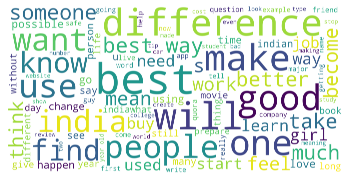

In [ ]:
wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

In [ ]:
gc.collect()

22500

In [ ]:
word_cloud_text = ''.join(df[df['is_duplicate']==1]['question1'])
word_cloud_text += ''.join(df[df['is_duplicate']==1]['question2'])

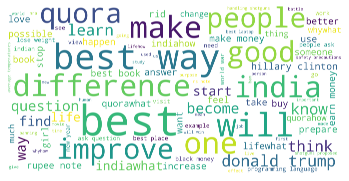

In [ ]:
wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

In [ ]:
del word_cloud_text
del wordcloud
gc.collect()

2445

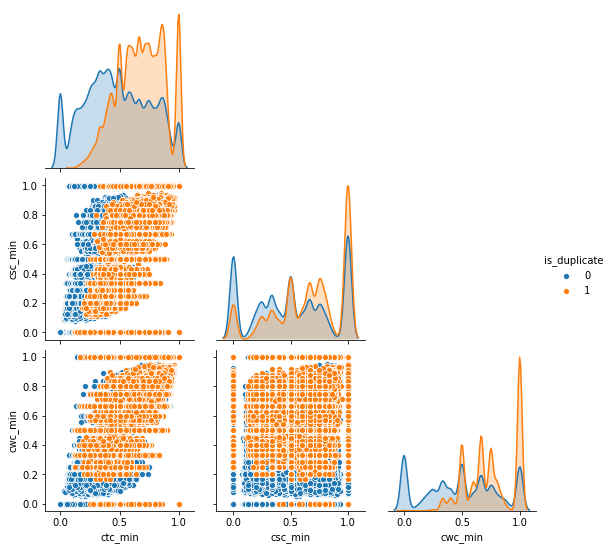

In [ ]:
sns.pairplot(df, vars=["ctc_min", "csc_min", "cwc_min"], hue='is_duplicate', corner=True)

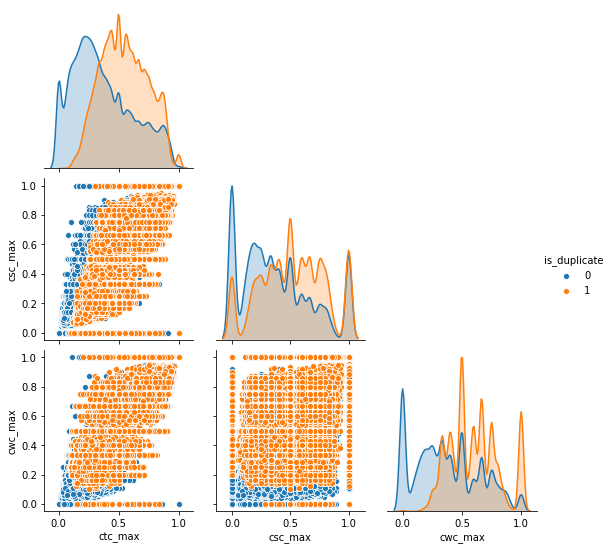

In [ ]:
sns.pairplot(df, vars=["ctc_max", "csc_max", "cwc_max"], hue='is_duplicate', corner=True)

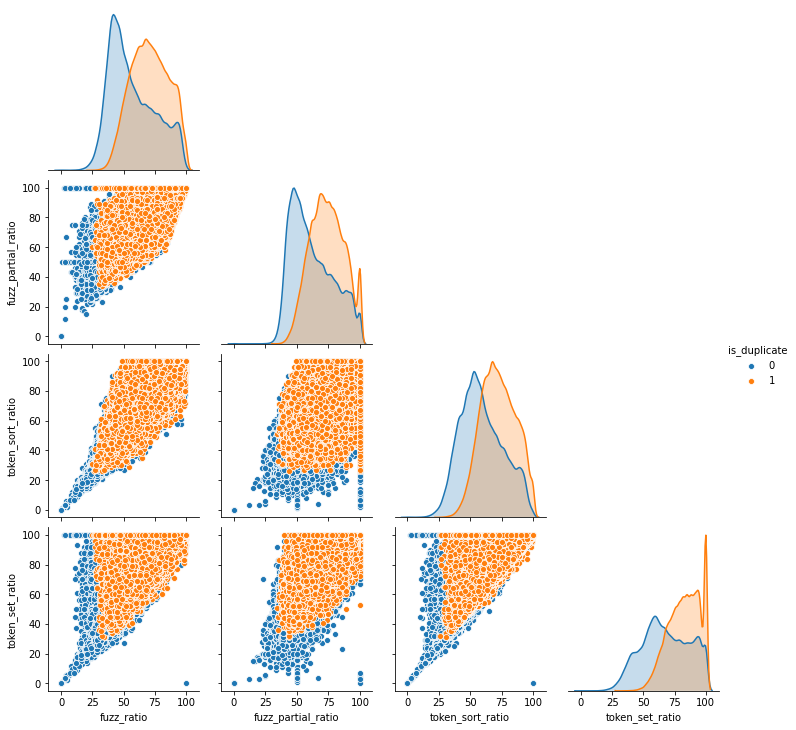

In [ ]:
sns.pairplot(df, vars=["fuzz_ratio", "fuzz_partial_ratio", "token_sort_ratio", "token_set_ratio"], hue='is_duplicate', corner=True)

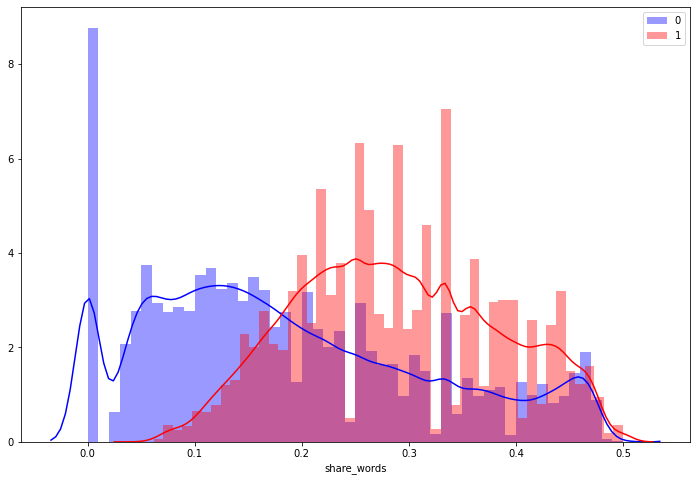

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 0]['share_words'][0:] , label = "0", color = 'blue')
sns.distplot(df[df['is_duplicate'] == 1]['share_words'][0:] , label = "1", color = 'red')
plt.legend()
plt.show()

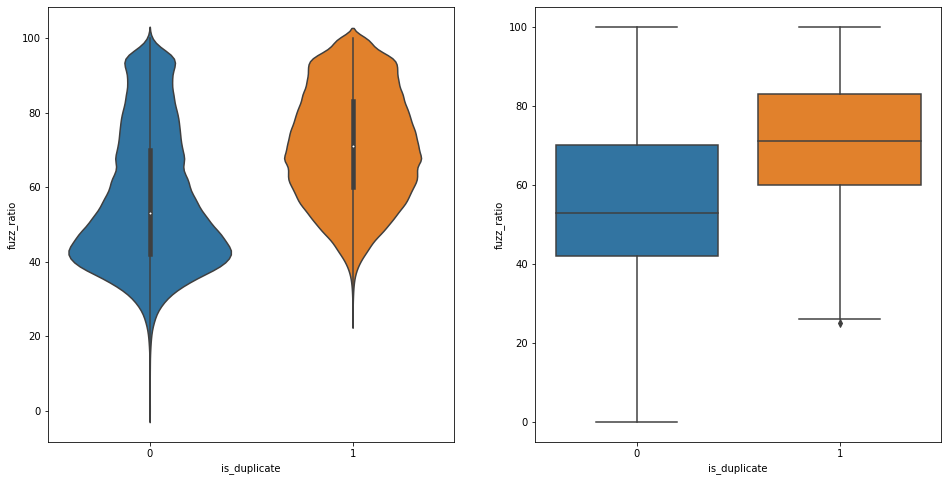

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='fuzz_ratio', data=df)
plt.subplot(1,2,2)
sns.boxplot(x='is_duplicate', y='fuzz_ratio', data=df)
plt.show()

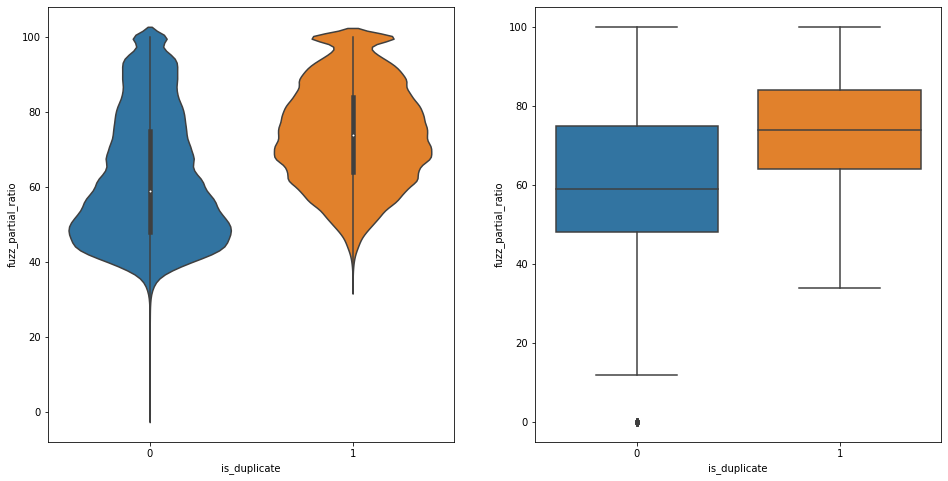

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='fuzz_partial_ratio', data=df)
plt.subplot(1,2,2)
sns.boxplot(x='is_duplicate', y='fuzz_partial_ratio', data=df)
plt.show()

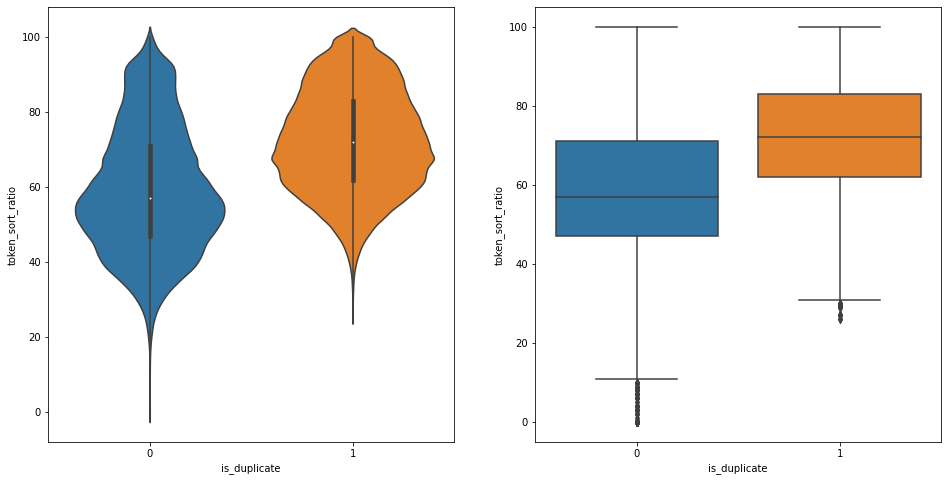

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio', data=df)
plt.subplot(1,2,2)
sns.boxplot(x='is_duplicate', y='token_sort_ratio', data=df)
plt.show()

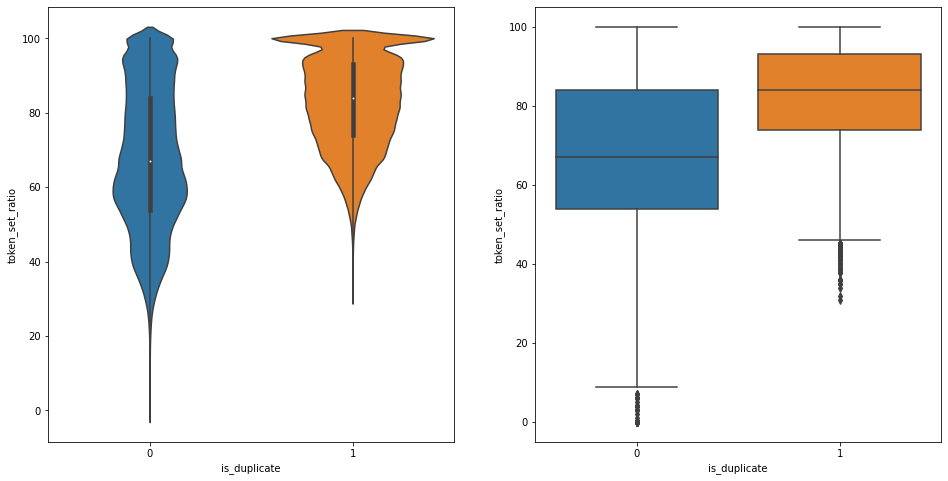

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='token_set_ratio', data=df)
plt.subplot(1,2,2)
sns.boxplot(x='is_duplicate', y='token_set_ratio', data=df)
plt.show()

## Visualizing using t-SNE

In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'first_word_eq', 'last_word_eq' , 'abs_len_diff' , 'mean_len' , 'fuzz_ratio' , 'fuzz_partial_ratio' , 'token_sort_ratio', 'token_set_ratio' ,'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values
del dfp_subsampled

In [ ]:
from sklearn.manifold import TSNE

# most are default values itself

tsne2d = TSNE(
    n_components=2,
#     init='random', # pca
    random_state=42,
#     method='barnes_hut',
#     n_iter=1000,
    verbose=2,
#     angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.369s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116911
[t-SNE] Computed conditional probabilities in 0.311s
[t-SNE] Iteration 50: error = 82.1105499, gradient norm = 0.0463100 (50 iterations in 1.914s)
[t-SNE] Iteration 100: error = 70.4871979, gradient norm = 0.0099316 (50 iterations in 1.391s)
[t-SNE] Iteration 150: error = 68.6470032, gradient norm = 0.0054022 (50 iterations in 1.232s)
[t-SNE] Iteration 200: error = 67.8029404, gradient norm = 0.0048088 (50 iterations in 1.217s)
[t-SNE] Iteration 250: error = 67.2894745, gradient norm = 0.0031034

/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


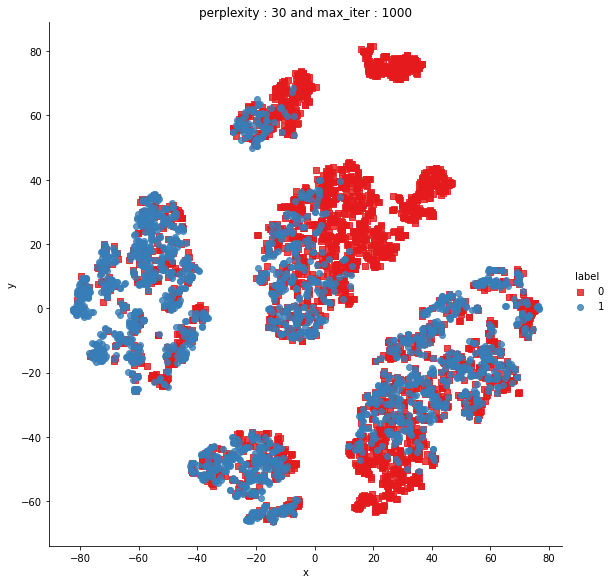

In [ ]:
df_temp = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_temp, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()
del df_temp
del tsne2d

In [ ]:
gc.collect()

37637

In [ ]:
### we will use tfidf weighted word2vectors and pretrained model

In [ ]:
# import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

- https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

In [ ]:
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)


# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [ ]:
# df.to_pickle('df_processes.df')

In [ ]:
# df_preprocess = pd.read_pickle('/kaggle/output/df_preprocess.df')
# df_preprocess.head()

In [ ]:
len(word2tfidf)

85185

In [ ]:
word2tfidf['step']

8.199454520140613

In [ ]:
# this is my corpus
questions[:10]

['what is the step by step guide to invest in share market in india',
 'what is the story of kohinoor koh i noor diamond',
 'how can i increase the speed of my internet connection while using a vpn',
 'why am i mentally very lonely how can i solve it',
 'which one dissolve in water quikly sugar salt methane and carbon di oxide',
 'astrology i am a capricorn sun cap moon and cap rising what does that say about me',
 'should i buy tiago',
 'how can i be a good geologist',
 'when do you use instead of',
 'motorola company can i hack my charter motorolla dcx3400']

## word2vec application

#### Different Models with which you can play
- https://github.com/RaRe-Technologies/gensim-data
#### Explaining using word2vec wrt another problem
- https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
#### official guide
- https://radimrehurek.com/gensim_3.8.3/sklearn_api/w2vmodel.html


In [ ]:
import gensim
import gensim.downloader as api

from nltk.tokenize import word_tokenize

info = api.info()
info

# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

In [ ]:
model = api.load("glove-wiki-gigaword-300")

In [ ]:
model.vector_size

300

In [ ]:
model.most_similar("cat")

[('dog', 0.6816747188568115),
 ('cats', 0.6815836429595947),
 ('pet', 0.5870364904403687),
 ('dogs', 0.540766716003418),
 ('feline', 0.48979705572128296),
 ('monkey', 0.48794347047805786),
 ('horse', 0.4732130169868469),
 ('pets', 0.4634858965873718),
 ('rabbit', 0.4608757495880127),
 ('leopard', 0.4585462808609009)]

In [ ]:
model['cat']

array([-0.29353  ,  0.33247  , -0.047372 , -0.12247  ,  0.071956 ,
       -0.23408  , -0.06238  , -0.0037192, -0.39462  , -0.69411  ,
        0.36731  , -0.12141  , -0.044485 , -0.15268  ,  0.34864  ,
        0.22926  ,  0.54361  ,  0.25215  ,  0.097972 , -0.087305 ,
        0.87058  , -0.12211  , -0.079825 ,  0.28712  , -0.68563  ,
       -0.27265  ,  0.22056  , -0.75752  ,  0.56293  ,  0.091377 ,
       -0.71004  , -0.3142   , -0.56826  , -0.26684  , -0.60102  ,
        0.26959  , -0.17992  ,  0.10701  , -0.57858  ,  0.38161  ,
       -0.67127  ,  0.10927  ,  0.079426 ,  0.022372 , -0.081147 ,
        0.011182 ,  0.67089  , -0.19094  , -0.33676  , -0.48471  ,
       -0.35406  , -0.15209  ,  0.44503  ,  0.46385  ,  0.38409  ,
        0.045081 , -0.59079  ,  0.21763  ,  0.38576  , -0.44567  ,
        0.009332 ,  0.442    ,  0.097062 ,  0.38005  , -0.11881  ,
       -0.42718  , -0.31005  , -0.025058 ,  0.12689  , -0.13468  ,
        0.11976  ,  0.76253  ,  0.2524   , -0.26934  ,  0.0686

In [ ]:
# Collapse the list of strings into a single long string for processing
# questions_string = ' '.join(questions)

# from nltk.tokenize import word_tokenize

# # Tokenize the string into words
# tokens = word_tokenize(questions_string)

# words = [word for word in tokens if not word in stop_words]

# # Print first 10 words
# words[:10]

In [ ]:
# vector_list = [model[word] for word in tokens if word in model.vocab]
# len(vector_list), len(vector_list[0])

In [ ]:
# import spacy
# nlp = spacy.load('en_core_web_sm')
# nlp(questions[0])

In [ ]:
# nlp('step').vector

In [ ]:
# this is a float value
word2tfidf[str('step')]

8.199454520140613

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
# nlp = spacy.load('en_core_web_sm')

import tqdm
from tqdm import notebook
import numpy as np

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in notebook.tqdm(list(df['question1'])):
#     doc1 = model(qu1) 
    tokens = word_tokenize(qu1)
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(tokens), 300])
    for word in tokens:
        # word2vec
#         vec1 = word1.vector
        if word in model.vocab:
            vec1 = model[word]
#         vec1 = np.array([model[word] word if word in model.vocab])
        # fetch df score
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

del vecs1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [ ]:
import gc
del questions
# del questions_string
# del X

gc.collect()

24

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
# nlp = spacy.load('en_core_web_sm')

import tqdm
from tqdm import notebook

vecs2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu2 in notebook.tqdm(list(df['question2'])):
#     doc1 = model(qu1) 
    tokens = word_tokenize(qu2)
    mean_vec2 = np.zeros([len(tokens), 300])
    # 384 is the number of dimensions of vectors 
#     mean_vec1 = np.zeros([len(tokens), len(tokens[0])])
    for word in tokens:
        
        # word2vec
#         vec1 = word1.vector
#     vec2 = [model[word] for word in tokens if word in model.vocab]
        if word in model.vocab:
            vec2 = model[word]
        # fetch df score
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

del vecs2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice.


In [ ]:
del model

gc.collect()

24

In [ ]:
len(df['q1_feats_m'][0])

300

In [ ]:
df['question1'][0]

'what is the step by step guide to invest in share market in india'

In [ ]:
df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            404280, 404281, 404282, 404283, 404284, 404285, 404286, 404287,
            404288, 404289],
           dtype='int64', length=404287)

In [ ]:
df_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
df_q1.head()


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-4.402881,-1.555301,7.168340,-10.246719,-3.060446,-1.726865,-7.055738,9.527639,3.166854,-113.751156,...,1.004221,-15.441094,-2.052980,4.428032,11.433927,41.714138,-12.328668,-17.671293,1.554943,-5.734123
1,2.353718,-6.975995,-0.010698,-12.339335,-11.306092,-8.674462,5.514706,-1.387521,-8.645040,-41.000939,...,0.217262,-1.338053,12.515245,-7.214503,-10.843199,1.235159,22.961632,-5.237807,2.591950,-4.500865
2,-15.781255,8.063734,1.286933,-10.064598,3.782370,-1.546796,5.531094,-4.221909,3.179263,-100.056305,...,-4.021484,-4.267533,-14.356230,-1.687250,2.427381,2.434027,-2.448736,1.863020,-11.019304,-6.822605
3,-1.731853,5.684070,0.044356,-8.287113,5.568938,3.360337,4.610067,9.418565,4.139323,-71.223865,...,3.104091,-14.841360,-0.137983,2.787162,3.728451,-9.508148,5.721291,0.410638,-6.612064,6.681023
4,-10.826817,12.033429,-4.836943,-41.820781,15.395751,-33.937162,19.457583,2.493898,9.097219,-110.861571,...,-64.152819,9.676321,-17.308303,-3.764236,28.794732,-13.622176,-1.313599,-41.777205,-11.622138,11.555272


In [ ]:
df_q2 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)
df_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-2.798700,0.601685,7.495147,-8.208766,-2.426747,0.801125,-6.510665,6.505828,5.435876,-100.926925,...,0.904924,-15.344416,-1.726482,2.916874,11.999003,32.687320,-13.348956,-15.472518,0.228851,-4.806543
1,2.014367,-3.556115,-7.176003,-0.920137,-11.527978,-24.214352,10.360427,-1.411438,-7.055503,-91.827337,...,10.376328,-12.477525,14.330285,-3.094166,-7.677425,12.143586,24.851707,-20.593921,5.155999,2.225006
2,-7.644030,9.093159,9.622565,-0.079284,6.081986,14.661296,2.163880,14.177748,21.712642,-92.566799,...,7.379841,-1.807032,-14.647057,3.274065,16.150117,4.992782,-7.809478,-6.339288,-4.037658,-14.741722
3,-16.444166,2.811552,15.565737,-4.644509,-14.087634,16.283024,7.421044,-14.174512,3.532996,-74.641279,...,6.391820,-35.718146,-4.696507,-9.065426,14.211681,35.397715,4.109059,-41.779222,-18.192775,-7.422034
4,0.257800,5.106119,-13.697802,-11.815626,1.577025,10.128764,6.560453,8.547179,6.832757,-54.200908,...,-16.678029,10.076711,3.682315,-2.976698,0.812527,-11.802834,4.339224,-13.879203,-2.541699,0.327647


In [ ]:
df_q1.rename(columns=str).columns + '_q1'

Index(['0_q1', '1_q1', '2_q1', '3_q1', '4_q1', '5_q1', '6_q1', '7_q1', '8_q1',
       '9_q1',
       ...
       '290_q1', '291_q1', '292_q1', '293_q1', '294_q1', '295_q1', '296_q1',
       '297_q1', '298_q1', '299_q1'],
      dtype='object', length=300)

In [ ]:
df_q2.rename(columns=str).columns + '_q2'

Index(['0_q2', '1_q2', '2_q2', '3_q2', '4_q2', '5_q2', '6_q2', '7_q2', '8_q2',
       '9_q2',
       ...
       '290_q2', '291_q2', '292_q2', '293_q2', '294_q2', '295_q2', '296_q2',
       '297_q2', '298_q2', '299_q2'],
      dtype='object', length=300)

In [ ]:
df_q1['id'] = df['id']
df_q2['id'] = df['id']

In [ ]:
df_temp = df_q1.merge(df_q2, how='left', on=df.index)
df_temp.head()

,key_0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y,id_y
0,0,-4.402881,-1.555301,7.168340,-10.246719,-3.060446,-1.726865,-7.055738,9.527639,3.166854,...,-15.344416,-1.726482,2.916874,11.999003,32.687320,-13.348956,-15.472518,0.228851,-4.806543,0
1,1,2.353718,-6.975995,-0.010698,-12.339335,-11.306092,-8.674462,5.514706,-1.387521,-8.645040,...,-12.477525,14.330285,-3.094166,-7.677425,12.143586,24.851707,-20.593921,5.155999,2.225006,1
2,2,-15.781255,8.063734,1.286933,-10.064598,3.782370,-1.546796,5.531094,-4.221909,3.179263,...,-1.807032,-14.647057,3.274065,16.150117,4.992782,-7.809478,-6.339288,-4.037658,-14.741722,2
3,3,-1.731853,5.684070,0.044356,-8.287113,5.568938,3.360337,4.610067,9.418565,4.139323,...,-35.718146,-4.696507,-9.065426,14.211681,35.397715,4.109059,-41.779222,-18.192775,-7.422034,3
4,4,-10.826817,12.033429,-4.836943,-41.820781,15.395751,-33.937162,19.457583,2.493898,9.097219,...,10.076711,3.682315,-2.976698,0.812527,-11.802834,4.339224,-13.879203,-2.541699,0.327647,4


In [ ]:
del df_q1
del df_q2
gc.collect()

20

In [ ]:
df_temp['id'] = df['id']
df_temp.head()

,key_0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y,id_y,id
0,0,-4.402881,-1.555301,7.168340,-10.246719,-3.060446,-1.726865,-7.055738,9.527639,3.166854,...,-1.726482,2.916874,11.999003,32.687320,-13.348956,-15.472518,0.228851,-4.806543,0,0.0
1,1,2.353718,-6.975995,-0.010698,-12.339335,-11.306092,-8.674462,5.514706,-1.387521,-8.645040,...,14.330285,-3.094166,-7.677425,12.143586,24.851707,-20.593921,5.155999,2.225006,1,1.0
2,2,-15.781255,8.063734,1.286933,-10.064598,3.782370,-1.546796,5.531094,-4.221909,3.179263,...,-14.647057,3.274065,16.150117,4.992782,-7.809478,-6.339288,-4.037658,-14.741722,2,2.0
3,3,-1.731853,5.684070,0.044356,-8.287113,5.568938,3.360337,4.610067,9.418565,4.139323,...,-4.696507,-9.065426,14.211681,35.397715,4.109059,-41.779222,-18.192775,-7.422034,3,3.0
4,4,-10.826817,12.033429,-4.836943,-41.820781,15.395751,-33.937162,19.457583,2.493898,9.097219,...,3.682315,-2.976698,0.812527,-11.802834,4.339224,-13.879203,-2.541699,0.327647,4,4.0


In [ ]:
df = df.merge(df_temp, how='left', on='id')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,...,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y,id_y
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,-15.344416,-1.726482,2.916874,11.999003,32.687320,-13.348956,-15.472518,0.228851,-4.806543,0.0
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,4,1,51,88,...,-12.477525,14.330285,-3.094166,-7.677425,12.143586,24.851707,-20.593921,5.155999,2.225006,1.0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,-1.807032,-14.647057,3.274065,16.150117,4.992782,-7.809478,-6.339288,-4.037658,-14.741722,2.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,1,1,50,65,...,-35.718146,-4.696507,-9.065426,14.211681,35.397715,4.109059,-41.779222,-18.192775,-7.422034,3.0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,3,1,76,39,...,10.076711,3.682315,-2.976698,0.812527,-11.802834,4.339224,-13.879203,-2.541699,0.327647,4.0


In [ ]:
del df_temp
gc.collect()

20

In [ ]:
# we need to drop some columns which are not necessary
y_true = df['is_duplicate']
df.drop(['qid1','qid2','question1','question2','id_x','id_y'], axis=1, inplace=True)

In [ ]:
df.drop(['is_duplicate','id'], axis=1, inplace=True)
df.head()

,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,1,1,66,57,14,12,10,23,0.434783,2,...,0.904924,-15.344416,-1.726482,2.916874,11.999003,32.687320,-13.348956,-15.472518,0.228851,-4.806543
1,4,1,51,88,8,13,4,20,0.200000,5,...,10.376328,-12.477525,14.330285,-3.094166,-7.677425,12.143586,24.851707,-20.593921,5.155999,2.225006
2,1,1,73,59,14,10,4,24,0.166667,2,...,7.379841,-1.807032,-14.647057,3.274065,16.150117,4.992782,-7.809478,-6.339288,-4.037658,-14.741722
3,1,1,50,65,11,9,0,19,0.000000,2,...,6.391820,-35.718146,-4.696507,-9.065426,14.211681,35.397715,4.109059,-41.779222,-18.192775,-7.422034
4,3,1,76,39,13,7,2,20,0.100000,4,...,-16.678029,10.076711,3.682315,-2.976698,0.812527,-11.802834,4.339224,-13.879203,-2.541699,0.327647


In [ ]:
df.drop(['key_0'], axis=1, inplace=True)
df.head()

,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,1,1,66,57,14,12,10,23,0.434783,2,...,0.904924,-15.344416,-1.726482,2.916874,11.999003,32.687320,-13.348956,-15.472518,0.228851,-4.806543
1,4,1,51,88,8,13,4,20,0.200000,5,...,10.376328,-12.477525,14.330285,-3.094166,-7.677425,12.143586,24.851707,-20.593921,5.155999,2.225006
2,1,1,73,59,14,10,4,24,0.166667,2,...,7.379841,-1.807032,-14.647057,3.274065,16.150117,4.992782,-7.809478,-6.339288,-4.037658,-14.741722
3,1,1,50,65,11,9,0,19,0.000000,2,...,6.391820,-35.718146,-4.696507,-9.065426,14.211681,35.397715,4.109059,-41.779222,-18.192775,-7.422034
4,3,1,76,39,13,7,2,20,0.100000,4,...,-16.678029,10.076711,3.682315,-2.976698,0.812527,-11.802834,4.339224,-13.879203,-2.541699,0.327647


In [ ]:
cols = list(df.columns)
for i in cols:
    df[i] = df[i].apply(pd.to_numeric)
#     print(type(df[i]))

In [ ]:
df.head()

,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,1,1,66,57,14,12,10,23,0.434783,2,...,0.904924,-15.344416,-1.726482,2.916874,11.999003,32.687320,-13.348956,-15.472518,0.228851,-4.806543
1,4,1,51,88,8,13,4,20,0.200000,5,...,10.376328,-12.477525,14.330285,-3.094166,-7.677425,12.143586,24.851707,-20.593921,5.155999,2.225006
2,1,1,73,59,14,10,4,24,0.166667,2,...,7.379841,-1.807032,-14.647057,3.274065,16.150117,4.992782,-7.809478,-6.339288,-4.037658,-14.741722
3,1,1,50,65,11,9,0,19,0.000000,2,...,6.391820,-35.718146,-4.696507,-9.065426,14.211681,35.397715,4.109059,-41.779222,-18.192775,-7.422034
4,3,1,76,39,13,7,2,20,0.100000,4,...,-16.678029,10.076711,3.682315,-2.976698,0.812527,-11.802834,4.339224,-13.879203,-2.541699,0.327647


In [ ]:
# del cols
# del model

# del tfidf
# del word2tfidf

gc.collect()

20

In [ ]:
y_true = list(map(int, y_true.values))

In [ ]:
df.to_pickle('final.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

NameError: name 'train_test_split' is not defined

## References
- https://medium.com/analytics-vidhya/quora-question-pairs-similarity-problem-8e3ae90441f0
- https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
- https://nbviewer.jupyter.org/github/chambliss/Notebooks/blob/master/Word2Vec_News_Analysis.ipynb
- https://github.com/RaRe-Technologies/gensim-data
- https://www.guru99.com/tokenize-words-sentences-nltk.html
- https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1
- 

### References:
- https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/notebook
- https://www.kaggle.com/philschmidt/quora-eda-model-selection-roc-pr-plots
- https://www.kaggle.com/sudalairajkumar/simple-leaky-exploration-notebook-quora
- https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
- https://www.kaggle.com/liananapalkova/simply-about-word2vec
- https://www.kaggle.com/utsavdm/quora-question-pairs
- https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm